# Groupby 

files needed = ('Most-Recent-Cohorts-Scorecard-Elements.csv' which is available [here](https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-Scorecard-Elements.csv))

We often want to know how groups differ. Do workers with econ degrees make more than workers with history degrees? Do men live longer than women? Does it matter how much education you have? 

Pandas provides the `groupby( )` method to ease computing statistics by group ([docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)). This kind of method shows up in many data-oriented computing languages and packages. The idea is summed up as 

> split-apply-combine

Here is the canonical [illustration](https://www.oreilly.com/library/view/learning-pandas/9781783985128/ch09s02.html). The big idea is to 
1. **Split** the data up into groups. The groups are defined by *key* variables.
2. **Apply** some method or function to each group: mean, std, max, etc. This returns a smaller bit of data, often just one number.
3. **Combine** the results of the 'apply' from each group into a new data structure.
  
  
Apply-split-combine is an incredibly powerful feature of pandas. We will cover the basics here. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('precision', 3)       # this tells pandas to print out 3 decimal places when we print a DataFrame

## College Scorecard
Let's take this opportunity to learn about a new dataset: [The College Scorecard](https://collegescorecard.ed.gov/data/). The data are compiled by the Dept. of Education to help students evaluate higher education institutions. The data are very well documented and include such juicy variables as: prices, after program debt levels, earnings, completion rates, information about student outcomes by family income and other demographic variables. 

We will be working off of the 'most recent institution-level data' file.

\[There is an [api](https://collegescorecard.ed.gov/data/documentation/), too, but we would all have to sign up for a key.\]



In [2]:
colscd = pd.read_csv('most-recent-cohorts-all-data-elements-1.csv', na_values=['PrivacySuppressed', 'NULL'], dtype={9:'str'})

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1729,1743,1909,1910,1911,1912,1913) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We are loading a new data set. Let's do our checks. 

In [3]:
colscd.shape

(6806, 1986)

In [4]:
colscd.head(2)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMENRUP_PARTTIME_POOLED_SUPP,FTFTPCTPELL,FTFTPCTFLOAN,UG12MN,G12MN,SCUGFFN,POOLYRS_FTFTAIDPCT,FTFTPCTPELL_POOLED_SUPP,FTFTPCTFLOAN_POOLED_SUPP,SCUGFFN_POOLED
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.319,0.706,0.714,5343.0,1165.0,1288.0,2.0,0.708,0.729,2698.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu,https://uab.studentaidcalculator.com/survey.aspx,...,0.247,0.379,0.535,14445.0,10498.0,2228.0,2.0,0.389,0.541,4176.0


In [5]:
colscd.tail(2)

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMENRUP_PARTTIME_POOLED_SUPP,FTFTPCTPELL,FTFTPCTFLOAN,UG12MN,G12MN,SCUGFFN,POOLYRS_FTFTAIDPCT,FTFTPCTPELL_POOLED_SUPP,FTFTPCTFLOAN_POOLED_SUPP,SCUGFFN_POOLED
6804,49005401,4182601,41826,HCI College - Fort Lauderdale Campus,Fort Lauderdale,FL,33309,Accrediting Commission of Career Schools and C...,www.hci.edu/,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6805,49146401,4227001,42270,ABC Adult School - Cabrillo Lane,Cerritos,CA,907037748,Council on Occupational Education,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will check the dtypes once we have dropped the variables we are not using.

Let's clean this up a bit. 

This dataset is too big for our needs. Let's rename the variables to something easier to understand and keep just a few variables that look interesting. 

In [6]:
colscd = colscd.rename(columns = {'CONTROL':'ownership', 'INSTNM':'name', 'STABBR':'state', 'PREDDEG':'type', 
                                  'SATVRMID':'sat_read_med', 'SATMTMID':'sat_math_med', 'SATWRMID':'sat_write_med', 
                                  'PCIP52':'sh_bus', 'PCIP11':'sh_cs', 'PCIP14':'sh_eng', 'PCIP26':'sh_bio', 
                                  'PCIP45':'sh_ss', 'PCIP51':'sh_health', 'PCIP09':'sh_com',
                                  'MD_EARN_WNE_P10':'earn_10', 'GRAD_DEBT_MDN_SUPP':'debt_at_grad'})

In [7]:
cols_to_keep = ['name', 'state', 'ownership', 'type',
                'sat_read_med',  'sat_math_med', 'sat_write_med',
                'sh_bus', 'sh_cs', 'sh_eng', 'sh_bio', 'sh_ss', 'sh_com', 'sh_health',
                'earn_10', 'debt_at_grad']

colscd = colscd[cols_to_keep]
colscd.head(3)

,name,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
0,Alabama A & M University,AL,1,3,475.0,465.0,414.0,0.158,0.059,0.118,0.093,0.035,0.000,0.000,31000.0,34500.0
1,University of Alabama at Birmingham,AL,1,3,555.0,555.0,NaN,0.191,0.014,0.081,0.088,0.032,0.037,0.226,41200.0,22500.0
2,Amridge University,AL,2,3,NaN,NaN,NaN,0.462,0.000,0.000,0.000,0.000,0.000,0.000,39600.0,25002.0


The ownership and type variables are coded as integers. I would rather they were easy to understand. We could use statements like

```python 
colscd.loc[colscd['type']==1, 'type'] = 'cert'
```
for each change we want to make, but that would get tedious. Instead, we will use the pandas method `.replace()`. We pass the `.replace()` method a dictionary in which the keys are the objects we want to replace and the values are what we want to replace them with. 

Let's take a look.

In [8]:
type_codes = {0:'na', 1:'cert', 2:'asc', 3:'bach', 4:'grad_only'}
colscd['type'] = colscd['type'].replace(type_codes)

own_codes = {1:'Public', 2:'Private nonprofit', 3:'Private profit'}
colscd['ownership'] = colscd['ownership'].replace(own_codes)
colscd.head()

,name,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
0,Alabama A & M University,AL,Public,bach,475.0,465.0,414.0,0.158,0.059,0.118,0.093,0.035,0.000,0.000,31000.0,34500.0
1,University of Alabama at Birmingham,AL,Public,bach,555.0,555.0,NaN,0.191,0.014,0.081,0.088,0.032,0.037,0.226,41200.0,22500.0
2,Amridge University,AL,Private nonprofit,bach,NaN,NaN,NaN,0.462,0.000,0.000,0.000,0.000,0.000,0.000,39600.0,25002.0
3,University of Alabama in Huntsville,AL,Public,bach,630.0,565.0,NaN,0.211,0.059,0.289,0.044,0.024,0.019,0.154,46700.0,22021.0
4,Alabama State University,AL,Public,bach,480.0,465.0,NaN,0.106,0.059,0.000,0.083,0.014,0.089,0.168,27700.0,32637.0


Set the index to the university name. 
How does the UW look?

In [9]:
colscd.set_index('name', inplace=True)
colscd.loc['University of Wisconsin-Madison']

state                 WI
ownership         Public
type                bach
sat_read_med       665.0
sat_math_med       700.0
sat_write_med      640.0
sh_bus             0.142
sh_cs              0.038
sh_eng             0.106
sh_bio             0.116
sh_ss              0.094
sh_com             0.059
sh_health          0.078
earn_10          56200.0
debt_at_grad     20500.0
Name: University of Wisconsin-Madison, dtype: object

We are a public university that predominantly gives out bachelor degrees. The largest major is business, then biology and engineering. Median earnings 10 years after graduating is 56k and median debt at graduation is 20k.

One last check before we get to work. 

In [10]:
colscd.dtypes

state             object
ownership         object
type              object
sat_read_med     float64
sat_math_med     float64
sat_write_med    float64
sh_bus           float64
sh_cs            float64
sh_eng           float64
sh_bio           float64
sh_ss            float64
sh_com           float64
sh_health        float64
earn_10          float64
debt_at_grad     float64
dtype: object

The data are in good shape. Let's explore `.groupby()`. 

## 1. Split: groupby( )
We pass `.groupby()` a 'key' which tells the method which variable to, well, group by. We will group by state. This is the **split** step.

What is `colscd_grouped`?

In [11]:
colscd.sample(5)

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
New York University,NY,Private nonprofit,bach,685.0,725.0,680.0,0.131,0.058,0.045,0.041,0.141,0.053,0.096,61900.0,21250.0
Delaware Learning Institute of Cosmetology,DE,Private profit,cert,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,8644.0
Interactive College of Technology,TX,Private profit,asc,NaN,NaN,NaN,1.000,0.000,0.000,0.000,0.000,0.000,0.000,23700.0,NaN
Aviation Institute of Maintenance-Chesapeake,VA,Private profit,cert,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,38100.0,20000.0
Holy Apostles College and Seminary,CT,Private nonprofit,bach,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.031,0.000,0.000,NaN,NaN


In [13]:
colscd_grouped = colscd.groupby('state')
print(type(colscd_grouped))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


A DataFrameGroupBy object. This is basically a DataFrame + the grouping information. 

What does it look like? A DataFrameGroupBy is an iterable object. It returns subsets of the original DataFrame by group. In our case, the groups are defined by state. 

The `.get_group()` returns a group. 

In [14]:
colscd_grouped

In [15]:
#colscd_grouped.get_group('WI').sort_index()

colscd_grouped.get_group('AK').sort_index()

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
Alaska Bible College,AK,Private nonprofit,bach,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN
Alaska Career College,AK,Private profit,cert,NaN,NaN,NaN,0.169,0.000,0.000,0.000,0.000,0.000,0.812,31200.0,9025.0
Alaska Christian College,AK,Private nonprofit,asc,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.125,NaN,NaN
Alaska Pacific University,AK,Private nonprofit,bach,NaN,NaN,455.0,0.143,0.000,0.000,0.048,0.000,0.000,0.000,40200.0,21552.0
Alaska Vocational Technical Center,AK,Public,cert,NaN,NaN,NaN,0.121,0.077,0.000,0.000,0.000,0.000,0.000,35300.0,5500.0
Ilisagvik College,AK,Public,cert,NaN,NaN,NaN,0.208,0.000,0.000,0.000,0.000,0.000,0.403,NaN,NaN
University of Alaska Anchorage,AK,Public,bach,NaN,NaN,NaN,0.131,0.022,0.050,0.022,0.031,0.012,0.238,45400.0,20671.0
University of Alaska Fairbanks,AK,Public,bach,585.0,575.0,510.0,0.095,0.014,0.098,0.035,0.022,0.013,0.169,38700.0,19407.0
University of Alaska Southeast,AK,Public,cert,NaN,NaN,NaN,0.208,0.000,0.000,0.026,0.036,0.002,0.197,36000.0,19696.0


...and there is every degree-granting institution in Wisconsin from [Academy of Cosmetology](https://www.tricociuniversity.edu/janesville-cosmetology-school/) to the [Wright Graduate University for the Realization of Human Potential](http://www.wrightgrad.edu/).

## 2. + 3. Apply and combine
A major use of groupby is to perform some kind of aggregation. This is the **apply** and **combine** step. Let's take the grouped data and compute some means. 

In [16]:
all_means = colscd_grouped.mean()  # apply the mean operator to the grouped data

print(type(all_means))             # what do we get back?

<class 'pandas.core.frame.DataFrame'>


In [17]:
# Ah, a DataFrame. We know what to do with that. 
all_means.head(10)

,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
state,,,,,,,,,,,,
AK,585.000,575.000,482.500,0.119,0.013,0.016,0.014,0.010,0.003,0.216,37800.000,15975.167
AL,538.364,534.182,498.000,0.112,0.019,0.014,0.024,0.012,0.013,0.239,32064.179,19899.138
AR,560.000,547.429,464.200,0.087,0.015,0.004,0.016,0.010,0.006,0.192,28280.952,14466.377
AS,NaN,NaN,NaN,0.109,0.000,0.021,0.000,0.008,0.000,0.105,22300.000,NaN
AZ,570.714,569.714,505.000,0.062,0.019,0.009,0.007,0.009,0.006,0.287,32896.154,13659.474
CA,587.189,589.527,570.540,0.090,0.021,0.007,0.013,0.029,0.014,0.259,37458.993,14222.645
CO,570.333,565.000,570.000,0.094,0.022,0.017,0.012,0.017,0.018,0.301,33889.855,15968.455
CT,588.118,583.824,532.083,0.088,0.016,0.026,0.021,0.036,0.017,0.244,42413.559,15143.706
DC,629.800,623.800,605.000,0.224,0.067,0.020,0.022,0.099,0.032,0.148,47600.000,23545.471


When we used `.mean()` on the grouped data, it **applied** the mean method to each group, which creates one number per group (for each column). It then **combined** the means into a DataFrame, one number per group per column. Nice.  

Notice that the categorical data (name, state, type) have been dropped. `.mean()` doesn't know what to do with string data.

Here we can see the result of `pd.set_option('precision', 3)`. The output is limited to 3 decimal places. 

## 1. + 2. + 3. Split-apply-combine

Computing the grouped data first helped us understand what was happening, but we can do the whole split-apply-combine in one step. One simple line of code.

In [16]:
all_means = colscd.groupby('state').mean()
all_means.head(10)

,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
state,,,,,,,,,,,,
AK,585.000,575.000,482.500,0.119,0.013,0.016,0.014,0.010,0.003,0.216,37800.000,15975.167
AL,538.364,534.182,498.000,0.112,0.019,0.014,0.024,0.012,0.013,0.239,32064.179,19899.138
AR,560.000,547.429,464.200,0.087,0.015,0.004,0.016,0.010,0.006,0.192,28280.952,14466.377
AS,NaN,NaN,NaN,0.109,0.000,0.021,0.000,0.008,0.000,0.105,22300.000,NaN
AZ,570.714,569.714,505.000,0.062,0.019,0.009,0.007,0.009,0.006,0.287,32896.154,13659.474
CA,587.189,589.527,570.540,0.090,0.021,0.007,0.013,0.029,0.014,0.259,37458.993,14222.645
CO,570.333,565.000,570.000,0.094,0.022,0.017,0.012,0.017,0.018,0.301,33889.855,15968.455
CT,588.118,583.824,532.083,0.088,0.016,0.026,0.021,0.036,0.017,0.244,42413.559,15143.706
DC,629.800,623.800,605.000,0.224,0.067,0.020,0.022,0.099,0.032,0.148,47600.000,23545.471


### Aggregation methods

Some common aggregation methods include: `.mean()`, `.sum()`, `.std()`, `.describe()`, `.min()`, `.max()`, but there are many more. Any function that returns a scalar will work. 

### groupby( ) on a subset of columns
We may not care about all the columns in our datset for a particular groupby. We can subset our DataFrame as usual and compute a groupby. This saves computing statistics we do not want. For a large data set, this can save time.

Let's focus on the median SAT scores. We will group by the 'ownership' variable.

In [18]:
colscd.head(2)

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
Alabama A & M University,AL,Public,bach,475.0,465.0,414.0,0.158,0.059,0.118,0.093,0.035,0.000,0.000,31000.0,34500.0
University of Alabama at Birmingham,AL,Public,bach,555.0,555.0,NaN,0.191,0.014,0.081,0.088,0.032,0.037,0.226,41200.0,22500.0


In [17]:
# Grab the cols we want from the df before using the groupby. Remember to keep the grouping variable, too.
sat_medians_1 = colscd[['sat_read_med', 'sat_math_med', 'sat_write_med', 'ownership']].groupby('ownership').median()
sat_medians_1

,sat_read_med,sat_math_med,sat_write_med
ownership,,,
Private nonprofit,560.0,550.0,505.0
Private profit,522.5,536.5,475.0
Public,555.0,547.0,490.0


## Practice

1. Create a dataset with only the public institutions from `colscd` DataFrame. Name it `pub`

In [20]:
#练习2

#1
pub = colscd[ colscd['ownership'] == 'Public']

pub.head(2)

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
Alabama A & M University,AL,Public,bach,475.0,465.0,414.0,0.158,0.059,0.118,0.093,0.035,0.000,0.000,31000.0,34500.0
University of Alabama at Birmingham,AL,Public,bach,555.0,555.0,NaN,0.191,0.014,0.081,0.088,0.032,0.037,0.226,41200.0,22500.0


In [18]:
#practice
#1
colscd_grouped_2 = colscd.groupby('ownership')
pub = colscd_grouped_2.get_group('Public').sort_index()
pub.head(5)

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
ABC Adult School,CA,Public,cert,NaN,NaN,NaN,0.388,0.107,0.0,0.000,0.000,0.0,0.369,NaN,NaN
ABC Adult School - Cabrillo Lane,CA,Public,na,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATEP at IVC,CA,Public,na,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36900.0,11000.0
Aaniiih Nakoda College,MT,Public,asc,NaN,NaN,NaN,0.238,0.048,0.0,0.000,0.000,0.0,0.238,20300.0,NaN
Abraham Baldwin Agricultural College,GA,Public,asc,525.0,505.0,NaN,0.070,0.007,0.0,0.023,0.004,0.0,0.249,32900.0,15550.0


The `.quantile( )` method ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html)) computes quantiles from the data. (e.g., `.quantile(0.5)` computes the median, or the the 50th quantile)

2. Let's look at a measure of the earnings variation for different institution types:

    a. Compute the 75th quantile for 'earn_10' for each 'type'. Name the new DataFrame 'q75'.  
    b. Compute the 50th quantile for 'earn_10' for each 'type'. Name the new DataFrame 'q50'.    
    c. Compute the 25th quantile for 'earn_10' for each 'type'. Name the new DataFrame 'q25'.
    
You should have three new DataFrames, each containing the one of the quantile statistics. 

In [21]:
#练习2

#2
q75 = pub[['type', 'earn_10']].groupby('type').quantile(q=0.75)

q75

,earn_10
type,
asc,34700.0
bach,48800.0
cert,33500.0
grad_only,146550.0
na,37000.0


In [22]:
q50 = pub[['type', 'earn_10']].groupby('type').quantile(q=0.5)

q50

,earn_10
type,
asc,31500.0
bach,42950.0
cert,29100.0
grad_only,89350.0
na,34600.0


In [23]:
q25 = pub[['type', 'earn_10']].groupby('type').quantile(q=0.25)

q25

,earn_10
type,
asc,28575.0
bach,37100.0
cert,26100.0
grad_only,50100.0
na,30100.0


2d. For each type, compute the difference between the 75 percentile and the 25 percentile and divide it by the median. 

This is sometimes called the *quartile-based coefficient of variation*. It is a measure of the variability of a variable. It is less sensitive to outliers than the coefficient of variation, which is the standard deviation divided by the mean. 

In [24]:
qbc = (q75-q25) / q50

qbc

,earn_10
type,
asc,0.194
bach,0.272
cert,0.254
grad_only,1.079
na,0.199


Wow, a lot of dispersion in the grad_only group. I wonder if that is from professional schools. Understanding the variation in income from different school types could be an interesting project. Let's practice some more. 



3. How do reading and writing scores correlate?

    a. Compute the median SAT reading and writing scores by **state**. 


In [29]:
#3
sat_medians_2 = colscd[['sat_read_med', 'sat_write_med', 'state']].groupby('state').median()

sat_medians_2

,sat_read_med,sat_write_med
state,,
AK,585.0,482.5
AL,545.0,500.0
AR,556.5,455.0
AS,NaN,NaN
AZ,595.0,505.0
CA,570.0,562.5
CO,560.0,580.0
CT,570.0,507.5
DC,665.0,620.0


3b. Create a scatter plot with the median reading score on the x axis and writing score on the y axis.  

If you finished early try:
1. Adding the 45-degree line to the plot. 
2. Replacing the data marker with the two-letter state abbreviation at each point

Text(0, 0.5, 'median SAT writing score')

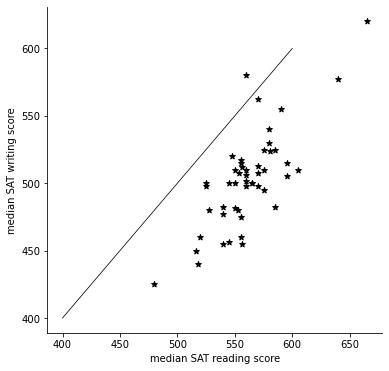

In [44]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(sat_medians_2['sat_read_med'], sat_medians_2['sat_write_med'], color = 'black', marker = '*')
ax.plot([400, 600], [400, 600], color='black', linewidth=0.75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('median SAT reading score')
ax.set_ylabel('median SAT writing score')

### Several statistics at once
Once we have grouped our data, we have been hitting it with methods to compute statistics: `mean()`, `count()`,...

We now introduced the `.agg( )` method, which lets us compute several moments at once&mdash;you can even pass it a user-defined function. 

In [25]:
# But agg() lets us compute many stats at once
colscd[['earn_10', 'sat_read_med', 'type']].groupby('type').agg(['count', 'mean', 'median', 'std', 'max'])

earn_10                                          sat_read_med  \
            count       mean   median        std       max        count   
type                                                                      
asc          1026  32099.123  31400.0   8046.405   90200.0           32   
bach         1805  44098.116  42800.0  12829.143  127900.0         1204   
cert         1668  26163.189  25000.0   9063.649   81500.0            3   
grad_only      64  94529.688  80250.0  57261.646  250000.0            0   
na            254  36302.362  34600.0  10947.080   72600.0            0   

                                          
              mean median     std    max  
type                                      
asc        502.594  499.0  49.381  690.0  
bach       566.782  560.0  61.381  760.0  
cert       519.333  523.0  62.581  580.0  
grad_only      NaN    NaN     NaN    NaN  
na             NaN    NaN     NaN    NaN

Now we have a multiIndex on the columns.

We can use `.agg()` to pass a user-defined function, too. We will work on that in the practice problems. 

### groupby( ) with many keys
Can we group by several keys? You know we can. Let's compute the medians this time.

In [46]:
sat_medians = colscd.groupby(['ownership','type']).median()
sat_medians

sat_read_med  sat_math_med  sat_write_med  \
ownership         type                                                   
Private nonprofit asc               480.0         470.0          455.0   
                  bach              560.0         550.0          510.0   
                  cert              523.0         510.0          480.0   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   
Private profit    asc               503.0         548.0            NaN   
                  bach              535.0         525.0          475.0   
                  cert                NaN           NaN            NaN   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   
Public            asc               505.0         490.0          435.0   
                  bach              555.0         550.0          490.0   
                  cert                NaN           NaN          391.0   
                  grad_only           NaN           NaN            NaN   
                  na                  NaN           NaN            NaN   

                             sh_bus  sh_cs  sh_eng  sh_bio  sh_ss  sh_com  \
ownership         type                                                      
Private nonprofit asc         0.000  0.000   0.000   0.000  0.000   0.000   
                  bach        0.155  0.006   0.000   0.039  0.012   0.010   
                  cert        0.000  0.000   0.000   0.000  0.000   0.000   
                  grad_only   0.000  0.000   0.000   0.000  0.000   0.000   
                  na            NaN    NaN     NaN     NaN    NaN     NaN   
Private profit    asc         0.039  0.000   0.000   0.000  0.000   0.000   
                  bach        0.245  0.037   0.000   0.000  0.000   0.000   
                  cert        0.000  0.000   0.000   0.000  0.000   0.000   
                  grad_only   0.000  0.000   0.000   0.000  0.000   0.000   
                  na            NaN    NaN     NaN     NaN    NaN     NaN   
Public            asc         0.098  0.027   0.000   0.000  0.000   0.000   
                  bach        0.168  0.028   0.003   0.045  0.043   0.036   
                  cert        0.032  0.009   0.000   0.000  0.000   0.000   
                  grad_only     NaN    NaN     NaN     NaN    NaN     NaN   
                  na            NaN    NaN     NaN     NaN    NaN     NaN   

                             sh_health  earn_10  debt_at_grad  
ownership         type                                         
Private nonprofit asc            0.324  33500.0       16166.0  
                  bach           0.032  42600.0       25000.0  
                  cert           0.576  26800.0       12000.0  
                  grad_only      0.000  82000.0       26165.0  
                  na               NaN  31850.0       24438.0  
Private profit    asc            0.520  27800.0       19539.5  
                  bach           0.043  44100.0       30750.0  
                  cert           0.000  21900.0        9500.0  
                  grad_only      0.000  34500.0       28975.5  
                  na               NaN  34600.0       17494.0  
Public            asc            0.181  31500.0       10500.0  
                  bach           0.099  42950.0       21500.0  
                  cert           0.343  29100.0        9500.0  
                  grad_only        NaN  89350.0       26000.0  
                  na               NaN  34600.0       12000.0

Now we have a MultiIndexed DataFrame with the summary statistics, this time, the median. 

The three ownership types all have institutions that predominately offer bachelors degrees. How do the median SAT scores compare across public and private institutions? 

Let's grab that set of statistics, a quick practice with multiIndex. 

In [47]:
bach_sat_med = sat_medians.xs('bach', level='type')         # xs() indexes data from a MultiIndex
print(bach_sat_med)

                   sat_read_med  sat_math_med  sat_write_med  sh_bus  sh_cs  \
ownership                                                                     
Private nonprofit         560.0         550.0          510.0   0.155  0.006   
Private profit            535.0         525.0          475.0   0.245  0.037   
Public                    555.0         550.0          490.0   0.168  0.028   

                   sh_eng  sh_bio  sh_ss  sh_com  sh_health  earn_10  \
ownership                                                              
Private nonprofit   0.000   0.039  0.012   0.010      0.032  42600.0   
Private profit      0.000   0.000  0.000   0.000      0.043  44100.0   
Public              0.003   0.045  0.043   0.036      0.099  42950.0   

                   debt_at_grad  
ownership                        
Private nonprofit       25000.0  
Private profit          30750.0  
Public                  21500.0  


## Practice
1. Write a function that returns the average of the 5 largest elements of a Series (a column of a DataFrame). Name the function 'avg5'.

The input, name it `x`,  will be a column of a DataFrame. The output is a single number. 

In [26]:
def avg5(x):
    top5 = x.sort_values()[-5:]   # sort x, then grab the five largest. sort defaults to descending
    avg = top5.mean() 
    return avg


2. Test your function on column 'a' of the DataFrame defined below. The answer should be 8.

```python
test = pd.DataFrame({'a':[1, 4, 6, 9, 10, 3, 7, 8], 'b':[2, 3, 4, 5, 6, 7, 8, 10] })
```


The command would look like: 
```python
avg5(test['a'])
```

In [27]:
test = pd.DataFrame({'a':[1, 4, 6, 9, 10, 3, 7, 8], 'b':[2, 3, 4, 5, 6, 7, 8, 10] })
avg5(test['a'])

8.0

Now return to `colscd`

3. Drop any observation that has 'debt_at_grad' == NaN. Use the `.dropna()` method ([docs](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.dropna.html)). 

```python
colscd.dropna(subset=['debt_at_grad'])
```

4. Compute the mean, median, and avg5 of 'debt_at_grad' by **'ownership'**. Compute them all at once using `.agg()`.

In [28]:
#3
colscd2 = colscd.dropna(subset = ['debt_at_grad'])

In [31]:
colscd2.head(2)

,state,ownership,type,sat_read_med,sat_math_med,sat_write_med,sh_bus,sh_cs,sh_eng,sh_bio,sh_ss,sh_com,sh_health,earn_10,debt_at_grad
name,,,,,,,,,,,,,,,
Alabama A & M University,AL,Public,bach,475.0,465.0,414.0,0.158,0.059,0.118,0.093,0.035,0.000,0.000,31000.0,34500.0
University of Alabama at Birmingham,AL,Public,bach,555.0,555.0,NaN,0.191,0.014,0.081,0.088,0.032,0.037,0.226,41200.0,22500.0


In [32]:
colscd2[['debt_at_grad','ownership']].groupby('ownership').agg(['mean','median',avg5])

debt_at_grad                  
                          mean   median     avg5
ownership                                       
Private nonprofit    22625.964  24628.0  44044.6
Private profit       13074.265   9833.0  43268.2
Public               14825.388  12423.5  35184.6

In [33]:
#4

colscd2.groupby('ownership')['debt_at_grad'].agg(['mean','median',avg5])


,mean,median,avg5
ownership,,,
Private nonprofit,22625.964,24628.0,44044.6
Private profit,13074.265,9833.0,43268.2
Public,14825.388,12423.5,35184.6


## Extra practice

If you want to practice some more, try writing three functions: One returns the 25 percentile, one returns the 50th percentile and one returns the 75 percentile. 


Then redo question 2 from the first practice, but using only one groupby and and the `.agg()` method. 

2. Let's look at a measure of the earnings spread for different institution types
   1. Compute the 75th quantile for 'earn_10' for each 'type'.
   2. Compute the 50th quantile for 'earn_10' for each 'type'.
   3. Compute the 25th quantile for 'earn_10' for each 'type'.

You should have only one new DataFrame, each containing the one of the quantile statistics.

2d. For each type, compute the difference between the 75 percentile and the 25 percentile and divide it by the median. 

This is sometimes called the *quartile-based coefficient of variation*. It is a measure of the variability of a variable. It is less sensitive to outliers than the coefficient of variation, which is the standard deviation divided by the mean. 

\[The simplest way to do this is to use a *lambda function*. We have not covered these in class but it would not be difficult to learn on your own. Try searching for 'pandas agg pass argument.'\]